In [7]:
!pip install lime shap

In [8]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning library
import sklearn
import warnings
warnings.filterwarnings("ignore")

import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular


# Our Method: Model-agnostic locally explainability Method

In [31]:
def generate_perturbations(data_point, num_samples=10, perturbation_factor=0.1):
    """
    Generate perturbations of a data point in a DataFrame.

    Parameters:
        data_point (pd.DataFrame): The data point represented as a pandas DataFrame.
        num_samples (int): Number of perturbed samples to generate.
        perturbation_factor (float): Factor by which to perturb each value.

    Returns:
        pd.DataFrame: DataFrame containing perturbed samples.
    """
    perturbations = []
    for _ in range(num_samples):
        perturbed_data = data_point.copy()
        for col, value in data_point.items():
            if pd.api.types.is_numeric_dtype(value):
                if pd.api.types.is_integer_dtype(value):
                    perturbed_data[col] = int(value + perturbation_factor * np.random.randn())
                else:
                    perturbed_data[col] = value + perturbation_factor * np.random.randn()
            elif pd.api.types.is_bool_dtype(value):
                perturbed_data[col] = not value
        perturbations.append(perturbed_data)
    return pd.concat(perturbations, ignore_index=True)


Feature Importances is our method to use a surrogate model on perturbated data points.

In [32]:
def feature_importances(df, surrogate_model, predictor):
  d = df.shape[0]
  res = []
  for i in range(d):
    data_point = df.iloc[[i]]
    X_HAT = generate_perturbations(data_point)
    Y_HAT = predictor.predict(X_HAT)
    F_HAT = surrogate_model()
    F_HAT.fit(X_HAT, Y_HAT)
    v = F_HAT.feature_importances_
    res.append(v)

  x = pd.DataFrame(pd.DataFrame(res).mean()).T
  x.columns = df.columns
  return x

Surrogate Model ( these models have to use an interpretable models, such as decision trees / random forest classifiers or other models that employ the feature_importances subroutine ).

In [52]:
surrogate_model_1 = DecisionTreeClassifier
surrogate_model_2 = RandomForestClassifier

# Titanic Survivors Dataset

## Data Analysis

Titanic Surviovrs Dataset:

https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

In [34]:
data = pd.read_csv('Datasets/titanic-survivors.csv')

In [35]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age Plot for All Passengers vs Survivors

<Axes: xlabel='Age', ylabel='Density'>

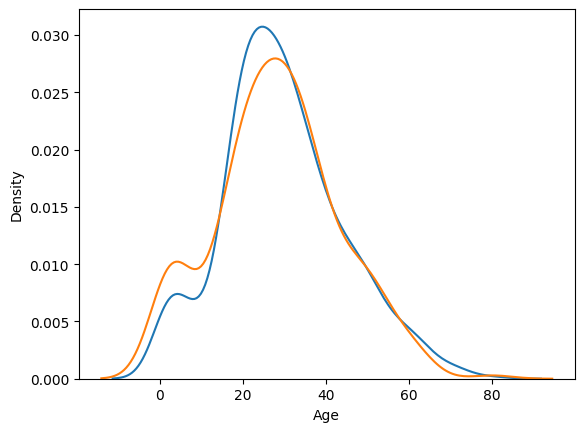

In [36]:
survived = data[data['Survived'] == 1]
sns.kdeplot(data['Age'])
sns.kdeplot(survived['Age'])

Sex Histogram for All passengers vs Survivors

Here we can see a significant bias towards the female race where females had 74.2% of surviving while males had only 18.89% of surviving

In [37]:
survival_counts = data.groupby('Sex')['Survived'].value_counts()
survival_percentages = (survival_counts / survival_counts.groupby(level=0).sum()) * 100

print(survival_percentages)

Sex     Survived
female  1           74.203822
        0           25.796178
male    0           81.109185
        1           18.890815
Name: count, dtype: float64


<Axes: >

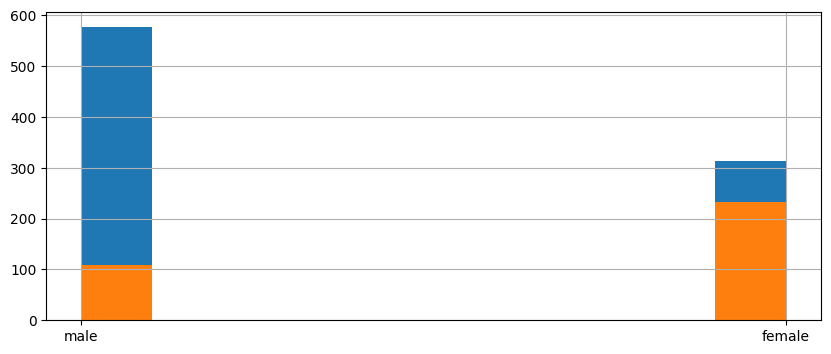

In [38]:
fig, ax = plt.subplots(figsize=(10,4))
data.Sex.hist(ax=ax)
survived.Sex.hist(ax=ax)

P Class is a proxy for socio-economic status (SES)


1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Histogram of All Passengers vs Survivors


<Axes: >

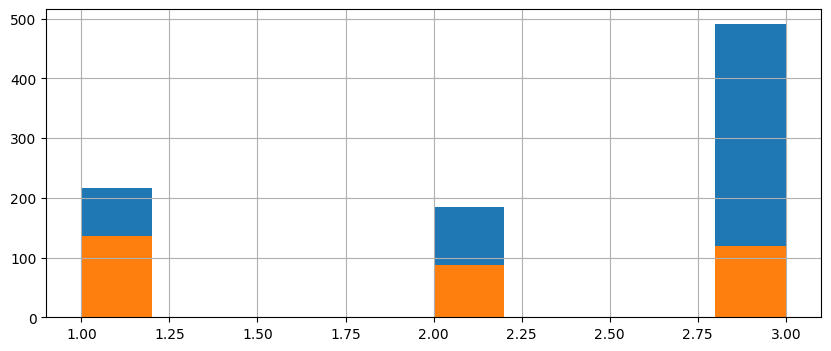

In [39]:
fig, ax = plt.subplots(figsize=(10,4))
data.Pclass.hist(ax=ax)
survived.Pclass.hist(ax=ax)

## Data Preprocessing

In [40]:
df = data.drop(columns=['Name','Ticket','Fare','Embarked','Cabin'])
df = df.replace('male', 0)
df = df.replace('female', 1)
df = df.dropna()

Here we can see a very large correlation between the Sex column to the Survived column in comparison to othe columns (pearson coefficent)

<Axes: >

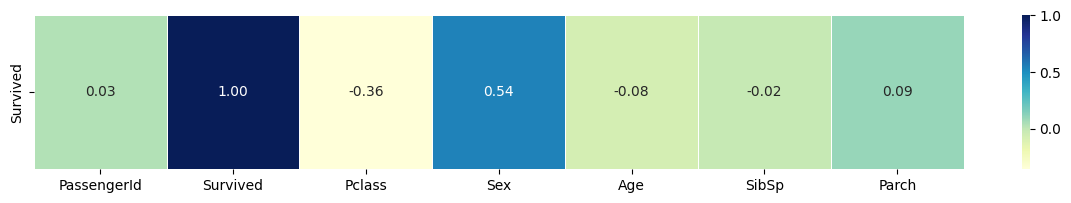

In [41]:
dtf_corr = df.corr(method="pearson").loc[["Survived"]]

fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

In [42]:
train, test = train_test_split(df, test_size=0.2)

In [43]:
X_train = train.drop(columns=['Survived'])
Y_train = train['Survived']
X_test = test.drop(columns=['Survived'])
Y_test = test['Survived']

In [44]:
X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch
875,876,3,1,15.00,0,0
521,522,3,0,22.00,0,0
642,643,3,1,2.00,3,2
512,513,1,0,36.00,0,0
856,857,1,1,45.00,1,1
...,...,...,...,...,...,...
690,691,1,0,31.00,1,0
161,162,2,1,40.00,0,0
803,804,3,0,0.42,0,1
352,353,3,0,15.00,1,1


## Biased Models
Here we generate two models that shall be examinated by our method, decision tree and random forest, however our method is model agnostic which can run on all types of models.

In [45]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
# Print Model Accuracy
print(f'DT Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f = decision_tree

DT Accuracy: 0.8111888111888111


In [25]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
# Print Model Accuracy
print(f'RF Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f2 = random_forest


RF Accuracy: 0.7832167832167832


### Model Explainability - Using SHAP to validate model is unfair
Let's validate that model's features using shap on 100 samples to validate the most imporatnt features. We can see that our trained model (decision tree in this case) is biased as Sex has the highest impact on prediction.

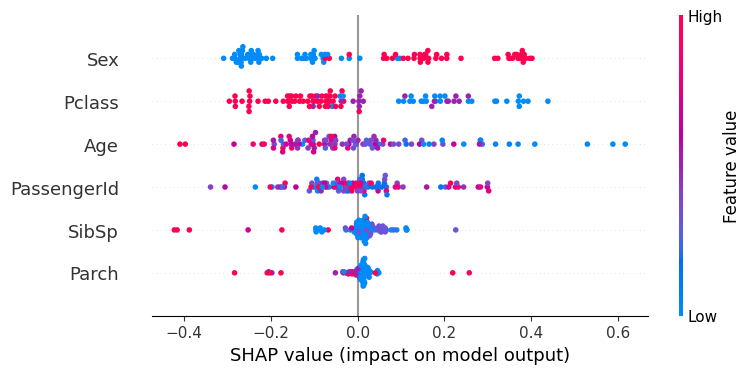

In [46]:
shap_sample = X_train.sample(100)
explainer = shap.Explainer(f.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

We'll do the same procedure to the other model we are testing which is Random Forest. We can see similar resulsts, concluding that both are biased models.

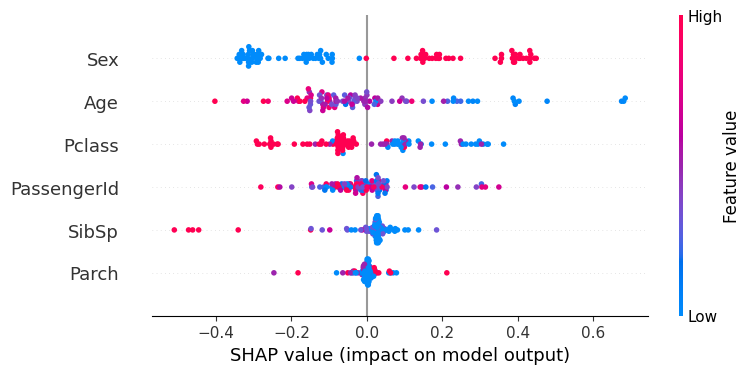

In [47]:
explainer = shap.Explainer(f2.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

## Result Comparison

In [58]:
def compare(df, surrogate_model, predictor=f):
  p1 = 'Sex'
  p2 = 'Pclass'
  p3 = 'Age'

  # Sex Comparison
  prot_df_p1 = df[df[p1] == 0]
  col1a = feature_importances(prot_df_p1, surrogate_model, predictor)[p1]
  unport_df_p1 = df[df[p1] == 1]
  col1b = feature_importances(unport_df_p1, surrogate_model, predictor)[p1]

  # P Class Comparison
  prot_df_p2 = df[df[p2] == 3]
  col2a = feature_importances(prot_df_p2, surrogate_model, predictor)[p2]
  unport_df_p2 = df[df[p2] != 3]
  col2b = feature_importances(unport_df_p2, surrogate_model, predictor)[p2]

  # Age Comparison
  prot_df_p3 = df[df[p3] <= 30]
  col3a = feature_importances(prot_df_p3, surrogate_model, predictor)[p3]
  unprot_df_p3 = df[df[p3] > 30]
  col3b = feature_importances(unprot_df_p3, surrogate_model, predictor)[p3]

  a = pd.DataFrame(pd.concat([col1a, col2a, col3a])).T
  a.columns =[p1, p2, p3]

  b = pd.DataFrame(pd.concat([col1b, col2b, col3b])).T
  b.columns =[p1, p2, p3]


  dim = pd.DataFrame(np.abs(a - b))
  print(f'Demographic Parity:')
  print(dim)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  X_axis = np.arange(len(a.columns))
  ax1.set_title('Feature Importance Means')
  ax1.bar(X_axis -0.2, a.values[0], 0.4, label='Protected')
  ax1.bar(X_axis +0.2, b.values[0], 0.4, label='Unprotected')
  ax1.set_xticks(X_axis, a.columns)
  ax1.legend()

  X_axis = np.arange(len(dim.columns))
  ax2.set_title("Demographic Parity")
  ax2.bar(X_axis, dim.values[0], label='DIM')
  ax2.set_xticks(X_axis, dim.columns)
  ax2.legend()

Let's use our method to explore whether Sex, Pclass or Age has high Demographic Parity

Demographic Parity:
        Sex    Pclass       Age
0  0.519396  0.006309  0.046099


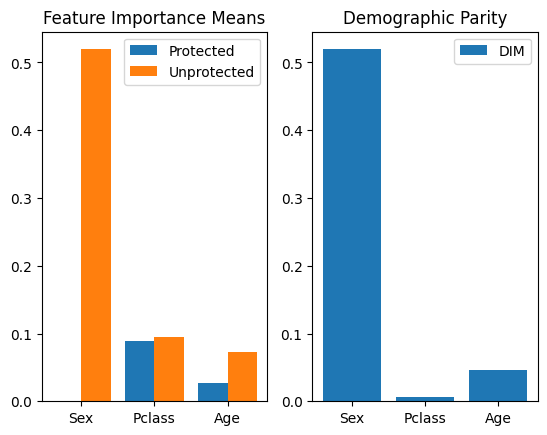

In [59]:
compare(X_test, surrogate_model_1, predictor=f)

Demographic Parity:
       Sex    Pclass       Age
0  0.66448  0.025025  0.018355


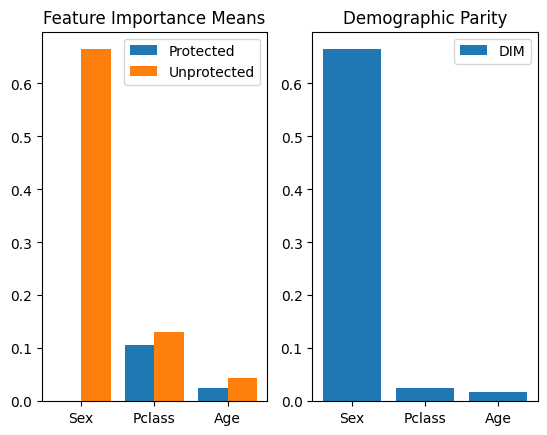

In [60]:
compare(X_test, surrogate_model_1, predictor=f2)

Demographic Parity:
        Sex    Pclass       Age
0  0.305778  0.000201  0.024764


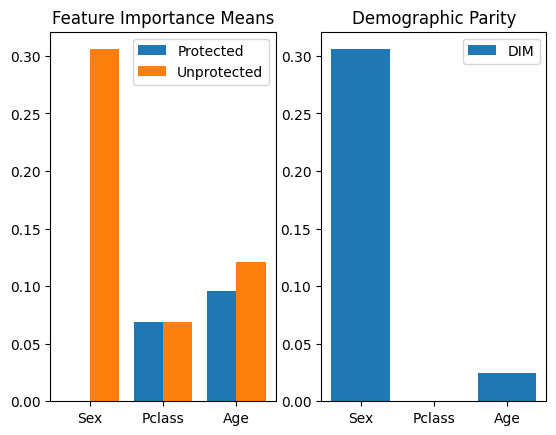

In [61]:
compare(X_test, surrogate_model_2, predictor=f)

Demographic Parity:
        Sex    Pclass       Age
0  0.379775  0.044544  0.027006


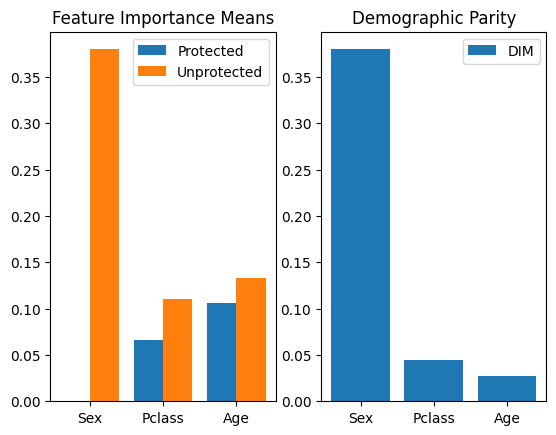

In [62]:
compare(X_test, surrogate_model_2, predictor=f2)

We can see that using our method we can claim that, on unseen data for both models (decision tree & random forest) are biased to the sex property. We observe the same result for both surrogate models.

### Extra ( Comparison with LIME )

Here we try to compare the explanation between our model and lime using the different surrogate models, we can see that for this example a female of 16 years old which is predicted to survive, our model claims that sex is the cause while lime claims that it's mostly sex & age together.

In [88]:
X_train.iloc[10]

PassengerId    330.0
Pclass           1.0
Sex              1.0
Age             16.0
SibSp            0.0
Parch            1.0
Name: 329, dtype: float64

In [84]:
feature_importances(X_train.iloc[[10]], surrogate_model_1 ,f)

,PassengerId,Pclass,Sex,Age,SibSp,Parch
0,0.0,0.0,1.0,0.0,0.0,0.0


In [83]:
feature_importances(X_train.iloc[[10]], surrogate_model_2 ,f)


,PassengerId,Pclass,Sex,Age,SibSp,Parch
0,0.05701,0.074049,0.52916,0.298108,0.0,0.041673


In [82]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, mode='classification', feature_names=['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch'])
# Assuming 'instance' is a single row from your DataFrame
explanation = explainer.explain_instance(X_train.iloc[10].values, f.predict_proba)
explanation.show_in_notebook()

# Adult Census Income

## Data Analysis

Adult Census Income Dataset:
https://www.kaggle.com/datasets/uciml/adult-census-income

In [101]:
data = pd.read_csv('Datasets/adults-census-income.csv')

In [102]:
data.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [103]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [104]:
df = data.drop(columns=['fnlwgt', 'education.num', 'capital.gain', 'capital.loss'])

In [105]:
df.head()

,age,workclass,education,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income
0,90,?,HS-grad,Widowed,?,Not-in-family,White,Female,40,United-States,<=50K
1,82,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,18,United-States,<=50K
2,66,?,Some-college,Widowed,?,Unmarried,Black,Female,40,United-States,<=50K
3,54,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,40,United-States,<=50K
4,41,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,40,United-States,<=50K


In [106]:
labels = {}
for attr in ['workclass', 'education', 'marital.status',
             'occupation', 'relationship', 'race',
             'sex', 'native.country', 'income']:
             labels[attr] = preprocessing.LabelEncoder()
             transform = labels[attr].fit_transform(df[attr])
             df[attr] = transform

In [107]:
df.head()

,age,workclass,education,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income
0,90,0,11,6,0,1,4,0,40,39,0
1,82,4,11,6,4,1,4,0,18,39,0
2,66,0,15,6,0,4,2,0,40,39,0
3,54,4,5,0,7,4,4,0,40,39,0
4,41,4,15,5,10,3,4,0,40,39,0


Here we compare the Age distribution of those that has more than 50k (blue) Income vs all participants (orange)

<Axes: xlabel='age', ylabel='Density'>

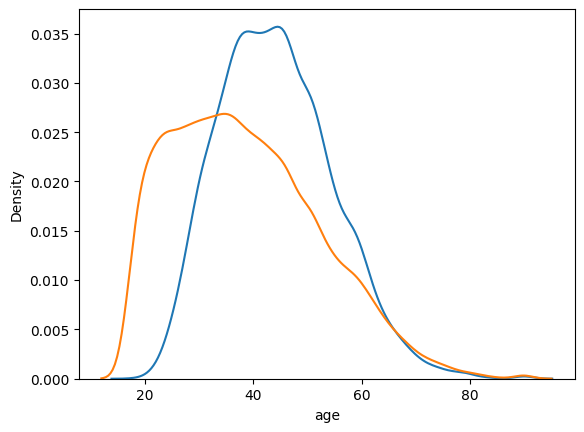

In [108]:
over50 = df[df['income'] > 0]
sns.kdeplot(over50['age'])
sns.kdeplot(df['age'])

Here we can see that only 10% of females earn more than 50K income, while 30% of males earn more than 50K income.

In [109]:
over50_counts = df.groupby('sex')['income'].value_counts()
over50_percentages = (over50_counts / over50_counts.groupby(level=0).sum()) * 100

print(over50_percentages)

sex  income
0    0         89.053941
     1         10.946059
1    0         69.426342
     1         30.573658
Name: count, dtype: float64


Sex Histogram for All Participants vs Those that earn more than 50K Income

[Text(0, 0, 'Female'), Text(1, 0, 'Male')]

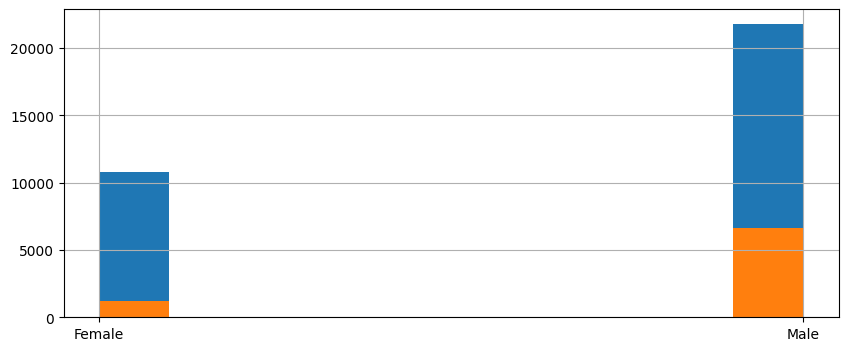

In [98]:
fig, ax = plt.subplots(figsize=(10,4))
df.sex.hist(ax=ax)
over50.sex.hist(ax=ax)
ax.set_xticks(sorted(df.sex.unique()))
ax.set_xticklabels(labels['sex'].classes_)

Histogram based on race, we can see far more examples of white people in comparison to others.

[Text(0, 0, 'Amer-Indian-Eskimo'),
 Text(1, 0, 'Asian-Pac-Islander'),
 Text(2, 0, 'Black'),
 Text(3, 0, 'Other'),
 Text(4, 0, 'White')]

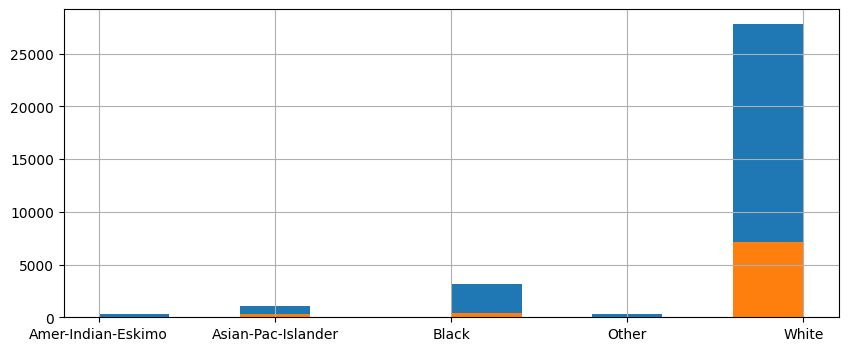

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
df.race.hist(ax=ax)
over50.race.hist(ax=ax)
ax.set_xticks(sorted(df.race.unique()))
ax.set_xticklabels(labels['race'].classes_)

Here we can see that highest correlation is: Age, Hours Per week & Sex.

<Axes: >

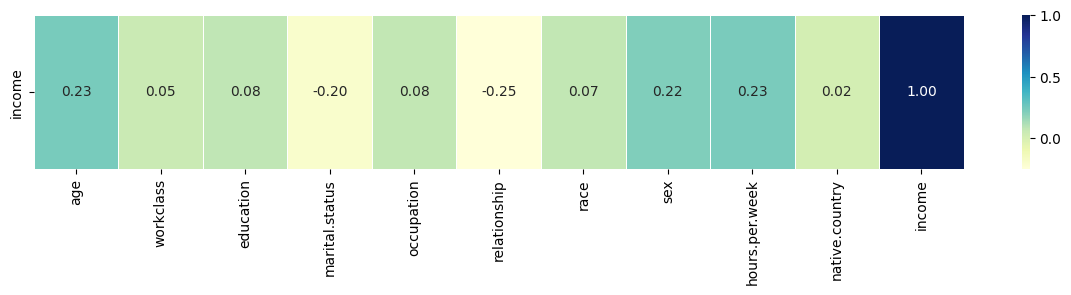

In [110]:
dtf_corr = df.corr(method="pearson").loc[["income"]]

fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

## Data Preprocessing

In [111]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [112]:
X_train = train.drop(columns=['income'])
Y_train = train['income']
X_test = test.drop(columns=['income'])
Y_test = test['income']

## Biased Models
Here we generate two models that shall be examinated by our method, decision tree and random forest, however our method is model agnostic which can run on all types of models.

In [118]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
# Print Model Accuracy
print(f'DT Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f = decision_tree

DT Accuracy: 0.7710732381391064


In [119]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
# Print Model Accuracy
print(f'RF Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f2 = random_forest


RF Accuracy: 0.8136035621065562


### Model Explainability - Using SHAP to validate whether model is unfair
Let's validate that model's features using shap on 100 samples to validate the most imporatnt features. We can see that our trained model (decision tree in this case) relies more on education, relationship & age rather than sex and race.

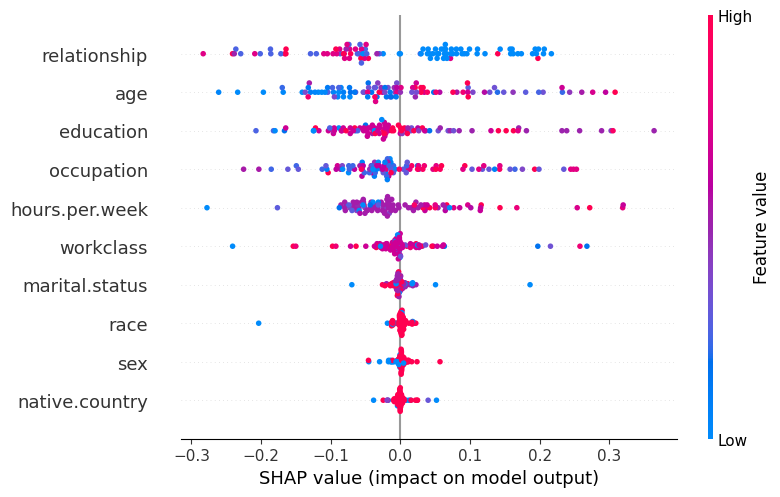

In [123]:
shap_sample = X_train.sample(100)
explainer = shap.Explainer(f.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

In conclusion we see that sex and race are less important features by Shap using the Decision Tree predictor.

## Result Comparison

In [126]:
def compare(df, surrogate_model, predictor=f):
  p1 = 'sex'
  p2 = 'race'
  p3 = 'age'

  # Sex Comparison
  prot_df_p1 = df[df[p1] == 0] # female
  col1a = feature_importances(prot_df_p1, surrogate_model, predictor)[p1]
  unport_df_p1 = df[df[p1] == 1] # male
  col1b = feature_importances(unport_df_p1, surrogate_model, predictor)[p1]

  # P Class Comparison
  prot_df_p2 = df[df[p2] == 2] # black
  col2a = feature_importances(prot_df_p2, surrogate_model, predictor)[p2]
  unport_df_p2 = df[df[p2] != 2] # non-black
  col2b = feature_importances(unport_df_p2, surrogate_model, predictor)[p2]

  # Age Comparison
  prot_df_p3 = df[df[p3] <= 25]
  col3a = feature_importances(prot_df_p3, surrogate_model, predictor)[p3]
  unprot_df_p3 = df[df[p3] > 25]
  col3b = feature_importances(unprot_df_p3, surrogate_model, predictor)[p3]

  a = pd.DataFrame(pd.concat([col1a, col2a, col3a])).T
  a.columns =[p1, p2, p3]

  b = pd.DataFrame(pd.concat([col1b, col2b, col3b])).T
  b.columns =[p1, p2, p3]


  dim = pd.DataFrame(np.abs(a - b))
  print(f'Demographic Parity')
  print(dim)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  X_axis = np.arange(len(a.columns))
  ax1.set_title('Feature Importance Means')
  ax1.bar(X_axis -0.2, a.values[0], 0.4, label='Protected')
  ax1.bar(X_axis +0.2, b.values[0], 0.4, label='Unprotected')
  ax1.set_xticks(X_axis, a.columns)
  ax1.legend()

  X_axis = np.arange(len(dim.columns))
  ax2.set_title("Demographic Parity")
  ax2.bar(X_axis, dim.values[0], label='DIM')
  ax2.set_xticks(X_axis, dim.columns)
  ax2.legend()

We can see that using our method with both surrogate models testing different predictors, there **is no bias found towards any sensitive property such as sex / race / age** as the demographic parity of each property is very low.

Demographic Parity
        sex      race      age
0  0.017932  0.003492  0.05681


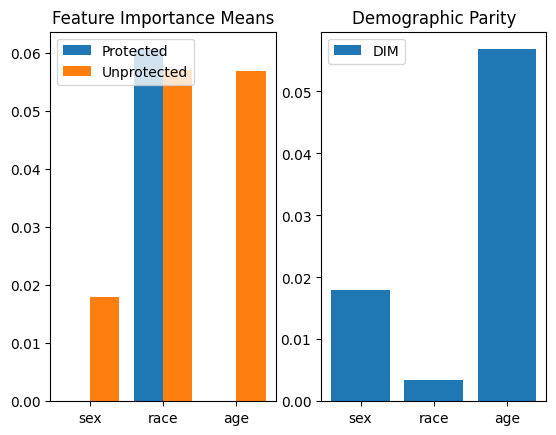

In [127]:
# Surrogate Decision Tree, Tested Model Decision Tree
compare(X_test.sample(100), surrogate_model_1, f)

Demographic Parity
        sex      race       age
0  0.053892  0.030928  0.018249


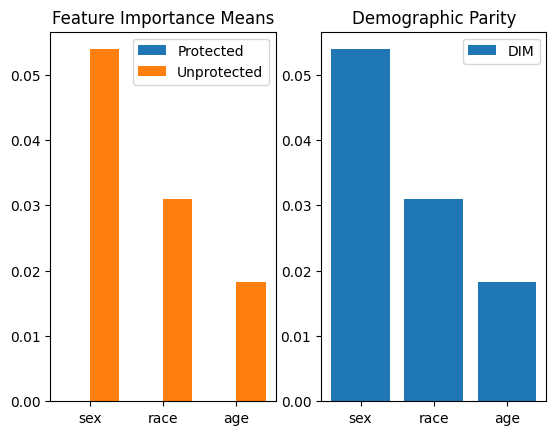

In [128]:
# Surrogate Decision Tree, Tested Model Random Forest
compare(X_test.sample(100), surrogate_model_1, f2)

Demographic Parity
        sex     race       age
0  0.059725  0.03838  0.040606


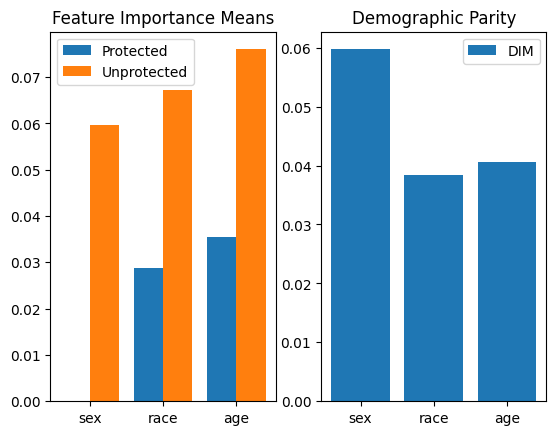

In [129]:
# Surrogate Random Forest, Tested Model Decision Tree
compare(X_test.sample(100), surrogate_model_2, f)

Demographic Parity
        sex      race       age
0  0.055211  0.020963  0.047603


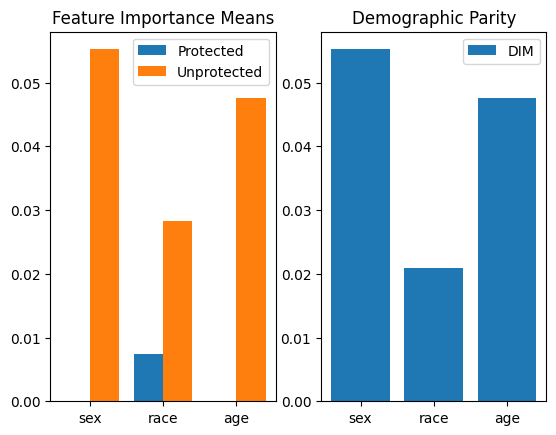

In [130]:
# Surrogate Random Forest, Tested Model Random Forest
compare(X_test.sample(100), surrogate_model_2, f2)

# Student Performance

## Data Analysis

In [240]:
data = pd.read_csv('Datasets/student-performance.csv')

In [241]:
data.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [242]:
data.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [243]:
data['race'] = data['race/ethnicity']

In [244]:
df = data.drop(columns=['reading score', 'writing score', 'race/ethnicity'])

In [245]:
df.head()

,gender,parental level of education,lunch,test preparation course,math score,race
0,female,bachelor's degree,standard,none,72,group B
1,female,some college,standard,completed,69,group C
2,female,master's degree,standard,none,90,group B
3,male,associate's degree,free/reduced,none,47,group A
4,male,some college,standard,none,76,group C


In [246]:
labels = {}
for attr in ['gender', 'race', 'parental level of education',
             'lunch', 'test preparation course']:
             labels[attr] = preprocessing.LabelEncoder()
             transform = labels[attr].fit_transform(df[attr])
             df[attr] = transform

In [247]:
df['over70'] = df['math score'] >= 70
over70 = df[df['over70'] > 0]

Here we plot the grade distrbution of math score to use it as an estimate for binning.

<Axes: xlabel='math score', ylabel='Density'>

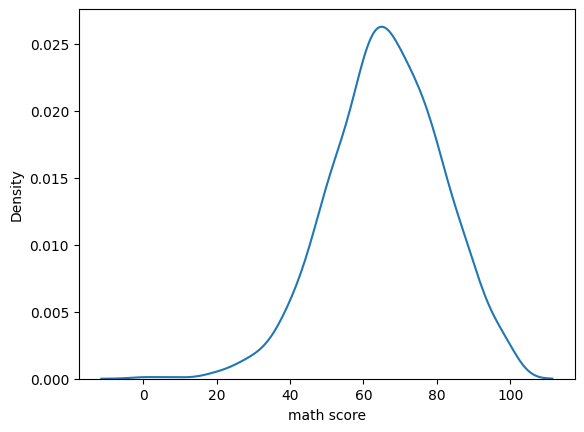

In [248]:
sns.kdeplot(df['math score'])

Here we can see a very small bias in the gender, where females has 34% to acheive grade of over 70 in math while males has 47%.

In [249]:
over70_counts = df.groupby('gender')['over70'].value_counts()
over70_percentages = (over70_counts / over70_counts.groupby(level=0).sum()) * 100

print(over70_percentages)

gender  over70
0       False     65.637066
        True      34.362934
1       False     52.074689
        True      47.925311
Name: count, dtype: float64


[Text(0, 0, 'female'), Text(1, 0, 'male')]

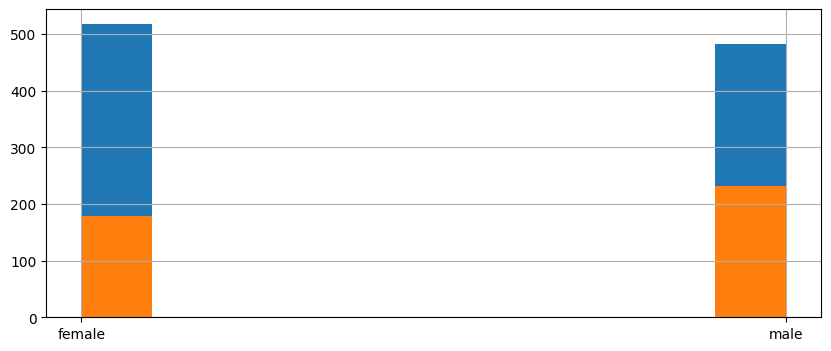

In [250]:
fig, ax = plt.subplots(figsize=(10,4))
df.gender.hist(ax=ax)
over70.gender.hist(ax=ax)
ax.set_xticks(sorted(df.gender.unique()))
ax.set_xticklabels(labels['gender'].classes_)

Here we can see the histogram of grades (over 70 in orange) vs all students divided by their race.

[Text(0, 0, 'group A'),
 Text(1, 0, 'group B'),
 Text(2, 0, 'group C'),
 Text(3, 0, 'group D'),
 Text(4, 0, 'group E')]

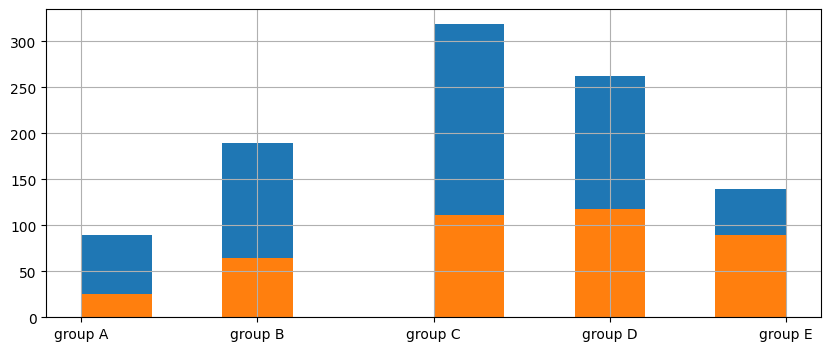

In [251]:
fig, ax = plt.subplots(figsize=(10,4))
df['race'].hist(ax=ax)
over70['race'].hist(ax=ax)
ax.set_xticks(sorted(df['race'].unique()))
ax.set_xticklabels(labels['race'].classes_)

Here we can see that highest correlation in the data is in the lunch property.

<Axes: >

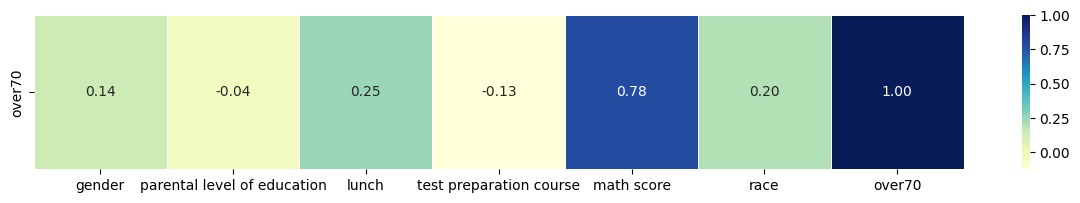

In [252]:
dtf_corr = df.corr(method="pearson").loc[["over70"]]

fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

## Data Preprocessing

In [253]:
train, test = train_test_split(df, test_size=0.2)

In [254]:
X_train = train.drop(columns=['over70', 'math score'])
Y_train = train['over70']
X_test = test.drop(columns=['over70', 'math score'])
Y_test = test['over70']

## Biased Models

In [255]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
# Print Model Accuracy
print(f'DT Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f = decision_tree

DT Accuracy: 0.645


In [256]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
# Print Model Accuracy
print(f'RF Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f2 = random_forest

RF Accuracy: 0.67


### Model Explainability - Using SHAP to validate whether model is unfair
Let's validate that model's features using shap on 100 samples to validate the most imporatnt features. We can see that our trained model (decision tree in this case) relies more on education, relationship & age rather than sex and race.

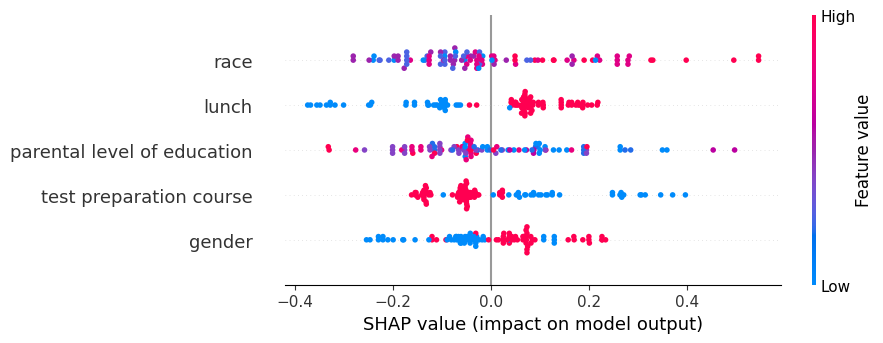

In [258]:
shap_sample = X_train.sample(100)
explainer = shap.Explainer(f.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

In conclusion we see that gender and race are less important features by Shap while lunch is more decisive, testing the Decision Tree predictor.

## Result Comparison

In [264]:
def compare(df, surrogate_model, predictor=f):
  p1 = 'gender'
  p2 = 'race'

  # Sex Comparison
  prot_df_p1 = df[df[p1] == 0] # female
  col1a = feature_importances(prot_df_p1, surrogate_model, predictor)[p1]
  unport_df_p1 = df[df[p1] == 1] # male
  col1b = feature_importances(unport_df_p1, surrogate_model, predictor)[p1]

  # Race Comparison
  prot_df_p2 = df[df[p2] == 0] # group a
  col2a = feature_importances(prot_df_p2, surrogate_model, predictor)[p2]
  unport_df_p2 = df[df[p2] != 0] # group b,c,d,
  col2b = feature_importances(unport_df_p2, surrogate_model, predictor)[p2]


  a = pd.DataFrame(pd.concat([col1a, col2a])).T
  a.columns =[p1, p2]

  b = pd.DataFrame(pd.concat([col1b, col2b])).T
  b.columns =[p1, p2]


  dim = pd.DataFrame(np.abs(a - b))
  print(f'Demographic Parity')
  print(dim)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  X_axis = np.arange(len(a.columns))
  ax1.set_title('Feature Importance Means')
  ax1.bar(X_axis -0.2, a.values[0], 0.4, label='Protected')
  ax1.bar(X_axis +0.2, b.values[0], 0.4, label='Unprotected')
  ax1.set_xticks(X_axis, a.columns)
  ax1.legend()

  X_axis = np.arange(len(dim.columns))
  ax2.set_title("Demographic Parity")
  ax2.bar(X_axis, dim.values[0], label='DIM')
  ax2.set_xticks(X_axis, dim.columns)
  ax2.legend()

Demographic Parity
     gender      race
0  0.213059  0.151762


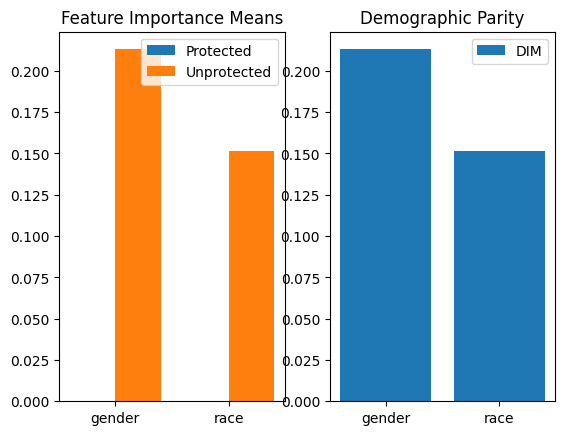

In [265]:
compare(X_test, surrogate_model_1, f)

Demographic Parity
     gender      race
0  0.173151  0.224757


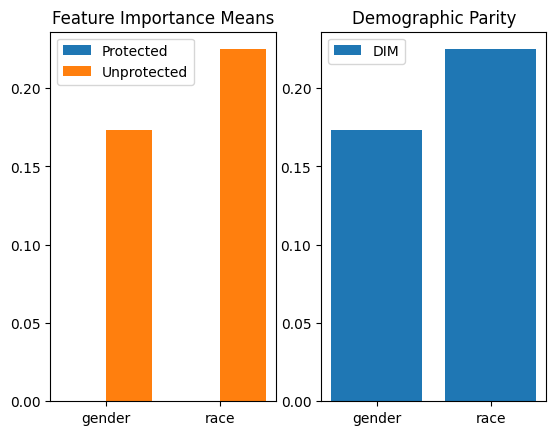

In [266]:
compare(X_test, surrogate_model_1, f2)

Demographic Parity
     gender      race
0  0.211238  0.143871


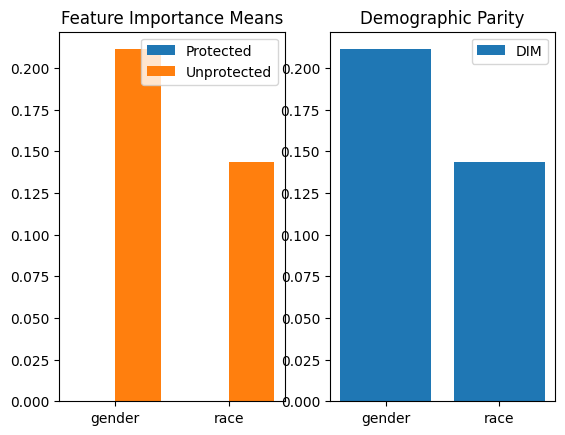

In [267]:
compare(X_test, surrogate_model_2, f)

Demographic Parity
     gender      race
0  0.165707  0.179778


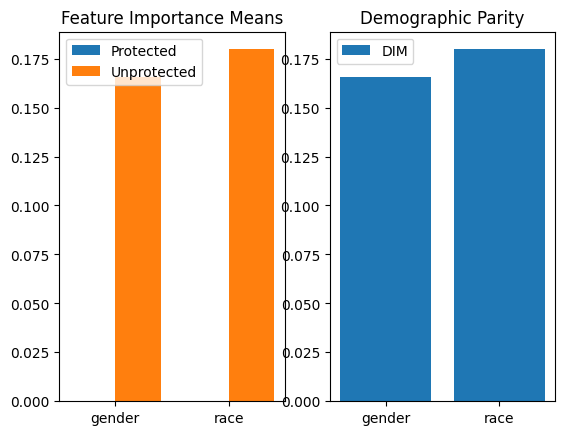

In [268]:
compare(X_test, surrogate_model_1, f2)

We can see that using our method with both surrogate models testing different predictors, there is a sleight (but not drasitcal) bias towards the unprotected groups in both race and gender as the demographic parity of each of these properties is not that high but not near 0.

# German Credit Risk

## Data Analysis

In [214]:
data = pd.read_csv('Datasets/german-credit.csv')

In [215]:
data.describe()

,Unnamed: 0,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,288.819436,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,249.750000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,499.500000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,749.250000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,999.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [216]:
data.columns

Index(['Unnamed: 0', 'Status of existing checking account',
       'Duration in month', 'Credit history', 'Purpose', 'Credit amount',
       'Savings account/bonds', 'Present employment since',
       'Installment rate in percentage of disposable income',
       'Personal status and sex', 'Other debtors / guarantors',
       'Present residence since', 'Property', 'Age in years',
       'Other installment plans', 'Housing',
       'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for', 'Telephone',
       'foreign worker', 'Cost Matrix(Risk)'],
      dtype='object')

In [217]:
data.loc[data['Personal status and sex'] != 'female:divorced/separated/married', 'sex'] = 'Male'
data.loc[data['Personal status and sex'] == 'female:divorced/separated/married', 'sex'] = 'Female'
data.loc[data['foreign worker'] == 'yes', 'foreign'] = 'no'
data.loc[data['foreign worker'] != 'yes', 'foreign'] = 'yes'


data['duration'] = data['Duration in month']
data['history'] = data['Credit history']
data['purpose'] = data['Purpose']
data['current_work_preiod'] = data['Present employment since']
data['age'] = data['Age in years']
data['housing'] = data['Housing']
data['existing_credits'] = data['Number of existing credits at this bank']
data['job'] = data['Job']
data['num_liabilities'] = data['Number of people being liable to provide maintenance for']
data['risk'] = data['Cost Matrix(Risk)']

df = data.drop(columns=['Status of existing checking account','Duration in month','Telephone', 'Credit amount', 'Unnamed: 0',
                          'Savings account/bonds', 'Installment rate in percentage of disposable income',
                          'Personal status and sex', 'Other debtors / guarantors',
                          'Present residence since', 'Property', 'Other installment plans',
                          'Number of existing credits at this bank', 'Housing', 'Age in years', 'Present employment since', 'Purpose', 'Credit history', 'Job',
                          'Number of people being liable to provide maintenance for', 'foreign worker', 'Cost Matrix(Risk)'])

In [218]:
df.head()

,sex,foreign,duration,history,purpose,current_work_preiod,age,housing,existing_credits,job,num_liabilities,risk
0,Male,no,6,critical account,radio/television,>=7 years,67,own,2,skilled employee / official,1,Good Risk
1,Female,no,48,existing credits paid back duly till now,radio/television,1<= < 4 years,22,own,1,skilled employee / official,1,Bad Risk
2,Male,no,12,critical account,education,4<= <7 years,49,own,1,unskilled - resident,2,Good Risk
3,Male,no,42,existing credits paid back duly till now,furniture/equipment,4<= <7 years,45,for free,1,skilled employee / official,2,Good Risk
4,Male,no,24,delay in paying off,car (new),1<= < 4 years,53,for free,2,skilled employee / official,2,Bad Risk


In [219]:
labels = {}
for attr in ['sex', 'history', 'purpose',
             'current_work_preiod', 'housing', 'job', 'foreign', 'risk']:
             labels[attr] = preprocessing.LabelEncoder()
             transform = labels[attr].fit_transform(df[attr])
             df[attr] = transform

We can see that bad risk is more dense around the median which is for younger people.

<Axes: xlabel='age', ylabel='Density'>

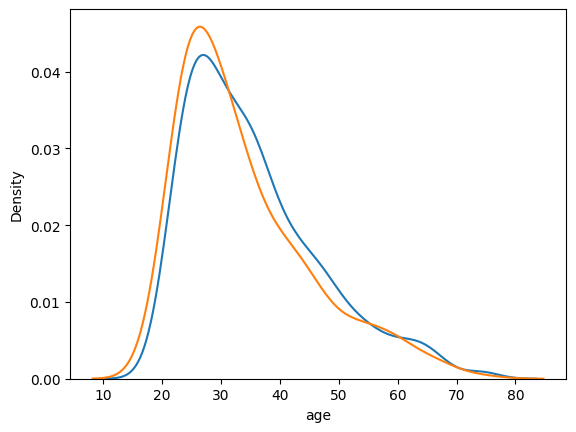

In [220]:
bad_risk = df[df['risk'] == 0]
sns.kdeplot(df['age'])
sns.kdeplot(bad_risk['age'])

In [221]:
bad_risk_counts = data.groupby('sex')['risk'].value_counts()
bad_risk_percentages = (bad_risk_counts / bad_risk_counts.groupby(level=0).sum()) * 100

print(bad_risk_percentages)

sex     risk     
Female  Good Risk    64.838710
        Bad Risk     35.161290
Male    Good Risk    72.318841
        Bad Risk     27.681159
Name: count, dtype: float64


[Text(0, 0, 'Female'), Text(1, 0, 'Male')]

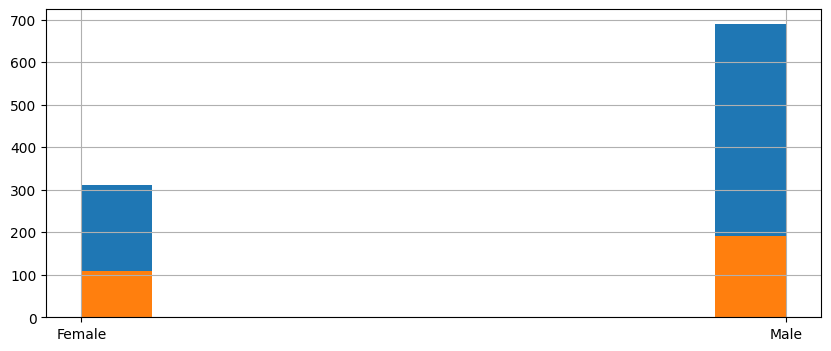

In [222]:
fig, ax = plt.subplots(figsize=(10,4))
df.sex.hist(ax=ax)
bad_risk.sex.hist(ax=ax)
ax.set_xticks(sorted(df.sex.unique()))
ax.set_xticklabels(labels['sex'].classes_)

[Text(0, 0, 'no'), Text(1, 0, 'yes')]

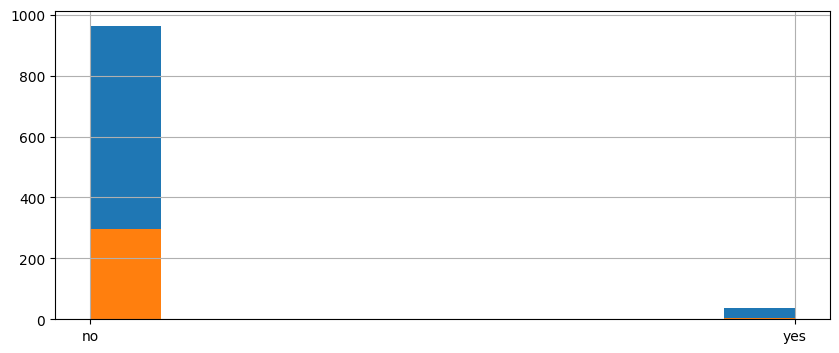

In [223]:
fig, ax = plt.subplots(figsize=(10,4))
df.foreign.hist(ax=ax)
bad_risk.foreign.hist(ax=ax)
ax.set_xticks(sorted(df.foreign.unique()))
ax.set_xticklabels(labels['foreign'].classes_)

<Axes: >

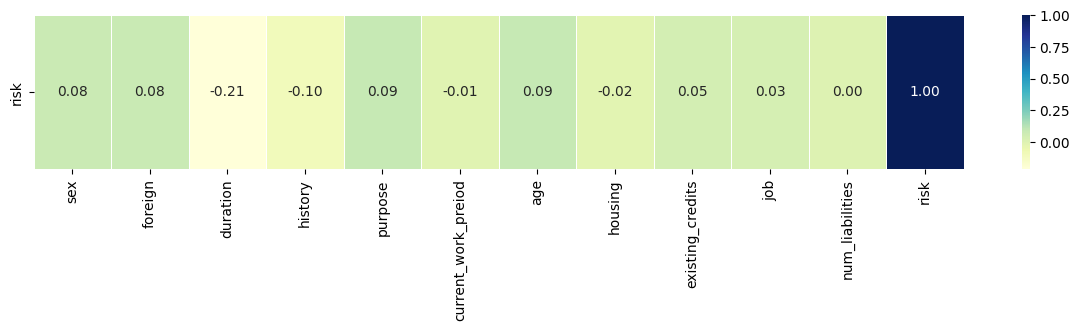

In [225]:
dtf_corr = df.corr(method="pearson").loc[["risk"]]

fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

## Data Preprocessing

In [227]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [228]:
X_train = train.drop(columns=['risk'])
Y_train = train['risk']
X_test = test.drop(columns=['risk'])
Y_test = test['risk']

In [229]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
# Print Model Accuracy
print(f'DT Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f = decision_tree

DT Accuracy: 0.64


In [230]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
# Print Model Accuracy
print(f'RF Accuracy: {(Y_pred == Y_test).sum() / Y_pred.shape[0]}')
f2 = random_forest


RF Accuracy: 0.695


### Model Explainability - Using SHAP to validate whether model is unfair
Let's validate that model's features using shap on 100 samples to validate the most imporatnt features. We can see that our trained model (decision tree in this case) relies more on education, relationship & age rather than sex and race.

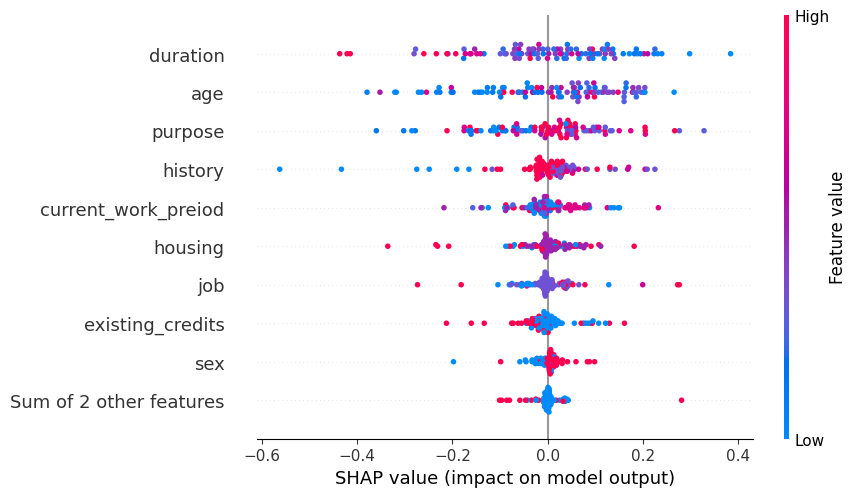

In [231]:
shap_sample = X_train.sample(100)
explainer = shap.Explainer(f.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

## Result Comparison

In [233]:
def compare(df, surrogate_model, predictor=f):
  p1 = 'sex'
  p2 = 'foreign'
  p3 = 'age'

  # Sex Comparison
  prot_df_p1 = df[df[p1] == 0] # female
  col1a = feature_importances(prot_df_p1, surrogate_model, predictor)[p1]
  unport_df_p1 = df[df[p1] == 1] # male
  col1b = feature_importances(unport_df_p1, surrogate_model, predictor)[p1]

  #  Foreign Comparison
  prot_df_p2 = df[df[p2] == 1] # Foreign
  col2a = feature_importances(prot_df_p2, surrogate_model, predictor)[p2]
  unport_df_p2 = df[df[p2] != 1] # Non-Foreign
  col2b = feature_importances(unport_df_p2, surrogate_model, predictor)[p2]

  # Age Comparison
  prot_df_p3 = df[df[p3] <= 28]
  col3a = feature_importances(prot_df_p3, surrogate_model, predictor)[p3]
  unprot_df_p3 = df[df[p3] > 28]
  col3b = feature_importances(unprot_df_p3, surrogate_model, predictor)[p3]

  a = pd.DataFrame(pd.concat([col1a, col2a, col3a])).T
  a.columns =[p1, p2, p3]

  b = pd.DataFrame(pd.concat([col1b, col2b, col3b])).T
  b.columns =[p1, p2, p3]


  dim = pd.DataFrame(np.abs(a - b))
  print(f'Demographic Parity')
  print(dim)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  X_axis = np.arange(len(a.columns))
  ax1.set_title('Feature Importance Means')
  ax1.bar(X_axis -0.2, a.values[0], 0.4, label='Protected')
  ax1.bar(X_axis +0.2, b.values[0], 0.4, label='Unprotected')
  ax1.set_xticks(X_axis, a.columns)
  ax1.legend()

  X_axis = np.arange(len(dim.columns))
  ax2.set_title("Demographic Parity")
  ax2.bar(X_axis, dim.values[0], label='DIM')
  ax2.set_xticks(X_axis, dim.columns)
  ax2.legend()

Demographic Parity
        sex   foreign       age
0  0.054648  0.029762  0.031969


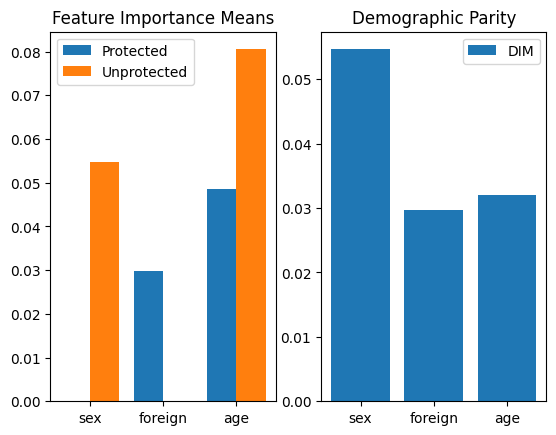

In [234]:
compare(X_test.sample(100), surrogate_model_1, f)

Demographic Parity
        sex  foreign       age
0  0.038462      0.0  0.006095


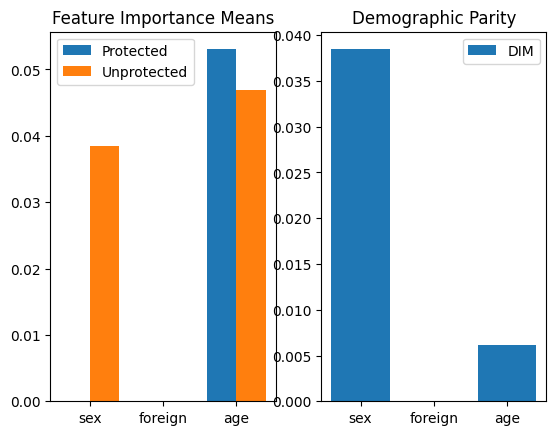

In [235]:
compare(X_test.sample(100), surrogate_model_1, f2)

Demographic Parity
        sex   foreign       age
0  0.066716  0.074933  0.016239


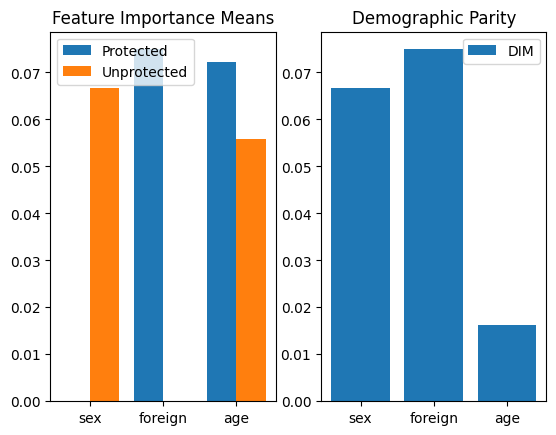

In [236]:
compare(X_test.sample(100), surrogate_model_2, f)

Demographic Parity
        sex   foreign       age
0  0.056233  0.059026  0.031968


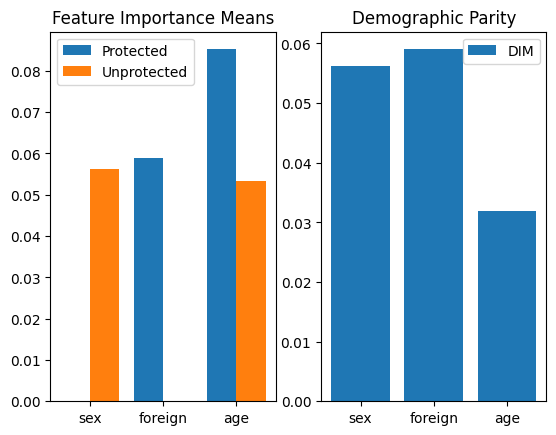

In [237]:
compare(X_test.sample(100), surrogate_model_2, f2)